# SOLEIL II optimize RoQ/Q0

Code to optimize RoQ/Q0 for a given beam current.

Is similar to Fig.7 in [1] (lower resolution and using Venturini solver to be faster).

[1] Gamelin, A., Gubaidulin, V., Alves, M. B., & Olsson, T. (2024). Semi-analytical algorithms to study longitudinal beam instabilities in double rf systems. arXiv preprint arXiv:2412.06539.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mbtrack2 import CavityResonator
from albums import scan_RoQ_Q0

mbtrack2 version 0.8.0.18
--------------------------------------------------
If used in a publication, please cite mbtrack2 paper and the zenodo archive for the corresponding code version (and other papers for more specific features).
[1] A. Gamelin, W. Foosang, N. Yamamoto, V. Gubaidulin and R. Nagaoka, “mbtrack2”. Zenodo, Dec. 16, 2024. doi: 10.5281/zenodo.14418989.
[2] A. Gamelin, W. Foosang, and R. Nagaoka, “mbtrack2, a Collective Effect Library in Python”, presented at the 12th Int. Particle Accelerator Conf. (IPAC'21), Campinas, Brazil, May 2021, paper MOPAB070.




## Ring and cavity setup

In [2]:
from mbtrack2.tracking import Synchrotron, Electron
from mbtrack2.utilities import Optics

def SOLEIL_II(V_RF=1.7e6):
    """
    SOLEIL II lattice v2366 w/ RF parameters from November 2023 RF budget.

    Parameters
    ----------
    V_RF : float, optional
        Total RF voltage in [V]. 
        The default is 1.7e6.
        
    Returns
    -------
    ring : Synchrotron object
        TDR lattice v2366_v3.

    """
    L = 353.97
    E0 = 2.75e9
    particle = Electron()
    ac = 1.05751e-04
    tune = np.array([54.2, 18.3])
    chro = np.array([1.6, 1.6])
    beta = np.array([3.288, 4.003])
    alpha = np.array([0, 0])
    dispersion = np.array([0, 0, 0, 0])
    h = 416
    particle = Electron()
    mcf_order = np.array([-0.00192226,  0.00061511,  0.00010695])
    U0 = 469e3
    tau = np.array([7.64e-3, 13.83e-3, 11.64e-3])
    sigma_delta = 9.063e-4
    emit = np.array([83.7e-12, 83.7e-12*0.01])
        
    optics = Optics(local_beta=beta, local_alpha=alpha, 
                  local_dispersion=dispersion)
    ring = Synchrotron(h, optics, particle, L=L, E0=E0, ac=ac, U0=U0, tau=tau,
                   emit=emit, tune=tune, sigma_delta=sigma_delta, chro=chro, 
                   mcf_order=mcf_order)
    
    tuneS = ring.synchrotron_tune(V_RF)
    ring.sigma_0 = (ring.sigma_delta * np.abs(ring.eta()) 
                    / (tuneS * 2 * np.pi * ring. f0))
    ring.get_longitudinal_twiss(V_RF)
        
    return ring

In [3]:
ring = SOLEIL_II(V_RF=1.7e6)

MC = CavityResonator(ring, m=1, Rs=5e6, Q=35.7e3, QL=6e3, detune=1e6, Ncav=4)
MC.Vc = 1.7e6
MC.theta = np.arccos(ring.U0/MC.Vc)

HC = CavityResonator(ring, m=4, Rs=2.358e6, Q=31e3, QL=31e3, detune=1e6, Ncav=1)

# Optimize scan RoQ/Q0

rank=0:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 15/21 [00:54<00:23,  3.91s/it]/home/gamelina/work/Python_dev/robinsonmodes/albums/robinson.py:639: RuntimeWarning: invalid value encountered in sqrt
  y0 = x[0] - np.sqrt(self._Omega_B13(x[0], x[1], bunch_length, omega_r, "-", abs_val))
/home/gamelina/anaconda3/envs/pycolleff/lib/python3.11/site-packages/scipy/optimize/_nonlin.py:931: RuntimeWarning: invalid value encountered in divide
  d = v / vdot(df, v)
rank=0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.05it/s]
/home/gamelina/work/Python_dev/robinsonmodes/albums/plot_func.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  i

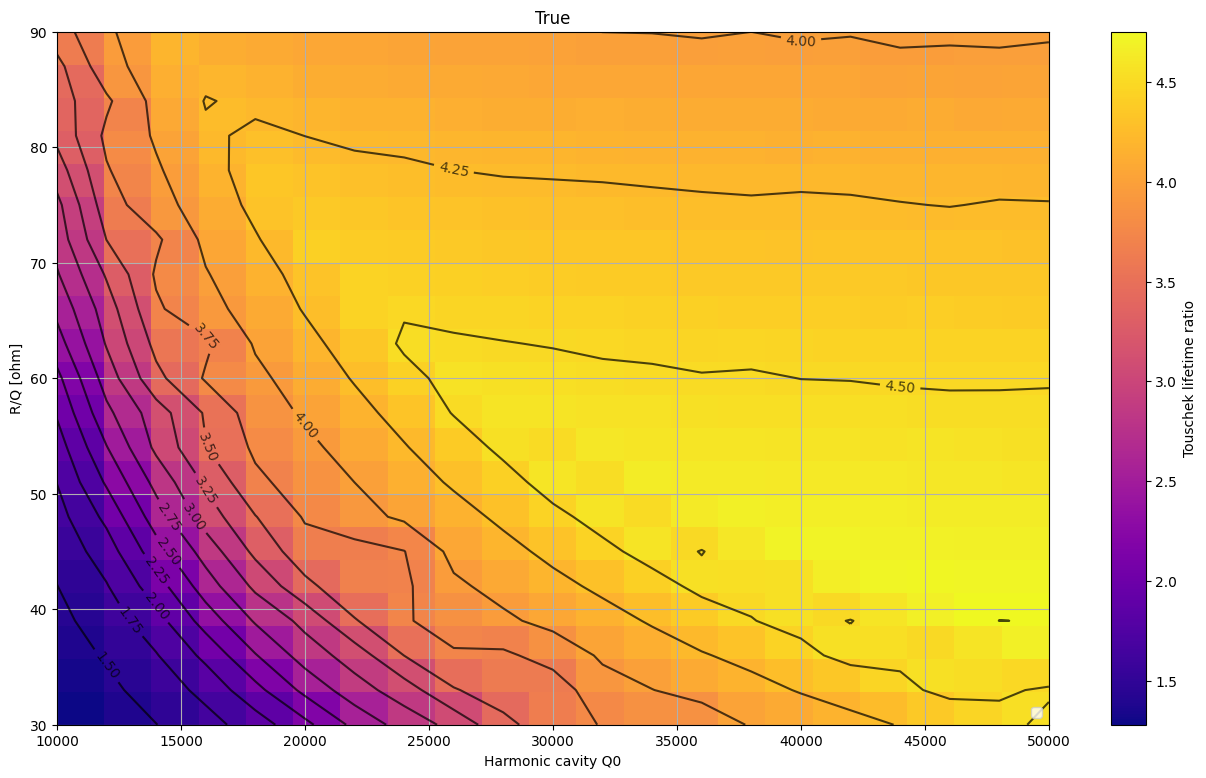

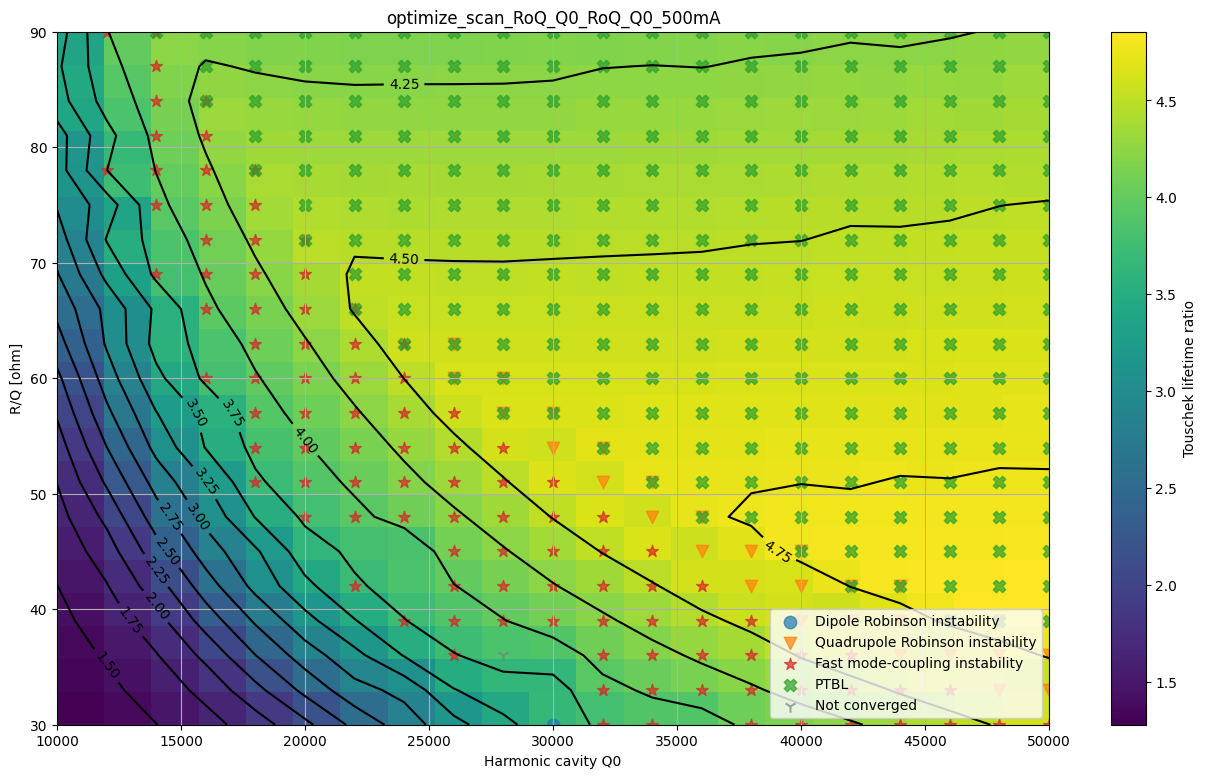

In [4]:
bounds = [20, 90] # Min/Max values for psi_HC
psi0_HC= 85 # Initial guess for psi_HC
I0 = 0.5 # Beam current, A

Q0_vals = np.linspace(10e3, 50e3, 21)
RoQ_vals = np.linspace(30, 90, 21)

scan_RoQ_Q0("optimize_scan_RoQ_Q0",
            MC,
            HC,
            ring,
            Q0_vals,
            RoQ_vals,
            I0,
            psi0_HC,
            bounds,
            tau_boundary=None,
            method="Venturini", # much faster for a notebook, set to "Alves" to get the same as in the paper
            plot_2D='R',
            save=False,
            set_MC_phase_HCpassive=True, # set the main cavity phase to cancel the losses in the HC
            auto_psi_input=True, # use xi_init_input instead of psi0_HC
            xi_init_input=0.8, # init guess for stable xi
            loop_option=True) # option to check the result of each optimization point 